## Deploy Stable Diffusion 2.1 model to SageMaker using Large Model Inference(LMI) container and DJLServing


Inference code and Model Server Properties
============================

You can provide custom inference code and model server configuration by specifying the ``source_dir`` and
``entry_point`` arguments of the ``DJLModel``. These are not required. The model server configuration can be generated
based on the arguments passed to the constructor, and we provide default inference handler code for DeepSpeed,
HuggingFaceAccelerate, and Stable Diffusion. You can find these handler implementations in the DJL Serving Github repository. https://github.com/deepjavalibrary/djl-serving/tree/master/engines/python/setup/djl_python

You can find documentation for the model server configurations on the `DJL Serving Docs website https://docs.djl.ai/docs/serving/serving/docs/configurations.html

The code and configuration you want to deploy can either be stored locally or in S3. These files will be bundled into
a tar.gz file that will be uploaded to SageMaker.

For example:

- code::
    - sourcedir/
         - script.py # Inference handler code
         - serving.properties # Model Server configuration file
         - requirements.txt # Additional Python requirements that will be installed at runtime via PyPi
    
    
In the below example, sourcedir will be bundled and compressed into a tar.gz file and uploaded as part of creating the Inference Endpoint.

The DJL Serving Model Server
============================

The endpoint you create with ``deploy`` runs the DJL Serving model server.
The model server loads the model from S3 and performs inference on the model in response to SageMaker ``InvokeEndpoint`` API calls.

DJL Serving is highly customizable. You can control aspects of both model loading and model serving. Most of the model server
configuration are exposed through the ``DJLModel`` API. The SageMaker Python SDK will use the values it is passed to
create the proper configuration file used when creating the inference endpoint. You can optionally provide your own
``serving.properties`` file via the ``source_dir`` argument. You can find documentation about serving.properties in the
`DJL Serving Documentation for model specific settings. https://docs.djl.ai/docs/serving/serving/docs/configurations.html#model-specific-settings

Within the SageMaker Python SDK, DJL Serving is used in Python mode. This allows users to provide their inference script,
and data processing scripts in python. For details on how to write custom inference and data processing code, please
see the DJL Serving Documentation on Python Mode. https://docs.djl.ai/docs/serving/serving/docs/modes.html#python-mode

For more information about DJL Serving, see the DJL Serving documentation. https://docs.djl.ai/docs/serving/index.html

In [1]:
!mkdir -p modelid/code

In [2]:
%%writefile modelid/code/serving.properties
engine=DeepSpeed
option.tensor_parallel_degree=1
#modelid is used when you directly want to reference a HuggingFace model.
# option.modelid=stabilityai/stable-diffusion-2-1-base

#---------------NOTE ------------------#
#Need to change this to your desired S3 bucket where the model artifacts from https://huggingface.co/stabilityai/stable-diffusion-2-1-base are downloaded.
#The instruction to download the model from HuggingFace Hub is here - https://huggingface.co/docs/hub/models-downloading , the artifact is about 60GB
option.s3url=s3://stable-diffusion-2-1-base/

option.dtype=fp16
option.enable_cuda_graph=True

Writing modelid/code/serving.properties


In [3]:
%%writefile modelid/code/requirements.txt
boto3
awscli

Writing modelid/code/requirements.txt


In [4]:
%%writefile modelid/code/model.py
import logging
import os
import torch
from diffusers import DiffusionPipeline
import deepspeed
from djl_python.inputs import Input
from djl_python.outputs import Output
from typing import Optional
from io import BytesIO
import boto3


def get_torch_dtype_from_str(dtype: str):
    if dtype == "fp16":
        return torch.float16
    raise ValueError(f"Invalid data type: {dtype}. DeepSpeed currently only supports fp16 for stable diffusion")


class StableDiffusionService(object):

    def __init__(self):
        self.pipeline = None
        self.initialized = False
        self.ds_config = None
        self.logger = logging.getLogger()
        self.model_id_or_path = None
        self.data_type = None
        self.device = None
        self.world_size = None
        self.max_tokens = None
        self.tensor_parallel_degree = None
        self.save_image_bucket = None
        self.save_image_prefix = None

    def initialize(self, properties: dict):
        self.model_id_or_path = properties.get("model_id") or properties.get("model_dir")
        self.data_type = get_torch_dtype_from_str(properties.get("dtype"))
        self.max_tokens = int(properties.get("max_tokens", "1024"))
        self.device = int(os.getenv("LOCAL_RANK", "0"))
        self.save_image_bucket = os.getenv("S3_SAVE_IMAGE_BUCKET")
        self.save_image_prefix = os.getenv("S3_SAVE_IMAGE_PREFIX")
        self.tensor_parallel_degree = int(
            properties.get("tensor_parallel_degree", 1))
        enable_cuda_graph = False
        if properties.get("enable_cuda_graph", "false").lower() == "true":
            if self.tensor_parallel_degree > 1:
                raise ValueError("enable_cuda_graph optimization can only be used with tensor_parallel_degree=1")
            enable_cuda_graph = True
        self.ds_config = self._get_ds_config_for_dtype(self.data_type, enable_cuda_graph)

        if os.path.exists(self.model_id_or_path):
            config_file = os.path.join(self.model_id_or_path, "model_index.json")
            if not os.path.exists(config_file):
                raise ValueError(
                    f"{self.model_id_or_path} does not contain a model_index.json."
                    f"This is required for loading stable diffusion models from local storage"
                )

        # DS 0.8.0 only supports fp16 and by this point we have validated dtype
        kwargs = {"torch_dtype": torch.float16, "revision": "fp16"}

        pipeline = DiffusionPipeline.from_pretrained(self.model_id_or_path, **kwargs)
        pipeline.to(f"cuda:{self.device}")
        deepspeed.init_distributed()
        engine = deepspeed.init_inference(getattr(pipeline, "model", pipeline),
                                          **self.ds_config)

        if hasattr(pipeline, "model"):
            pipeline.model = engine

        self.pipeline = pipeline
        self.initialized = True

    def _get_ds_config_for_dtype(self, dtype, cuda_graph):
        ds_config = {
            "enable_cuda_graph": cuda_graph,
            "dtype": dtype,
            "tensor_parallel": {"tp_size": self.tensor_parallel_degree},
            "replace_method": "auto",
            "replace_with_kernel_inject": True,
        }
        return ds_config

    def inference(self, inputs: Input):
        try:
            content_type = inputs.get_property("Content-Type")
            if content_type == "application/json":
                request = inputs.get_as_json()
                prompt = request.pop("prompt")
                prompt = [prompt] if type(prompt) == str else prompt
                params = request.pop("parameters")
                result = self.pipeline(prompt, **params)
            else:
                prompt = inputs.get_as_string()
                result = self.pipeline(prompt)
                
            for i, img in enumerate(result.images):
                image_name = f"image-{i}"
                buf = BytesIO()
                img.save(buf, format="PNG")
                buf.seek(0)
                s3_client.upload_fileobj(
                    buf,
                    self.save_image_bucket,
                    self.save_image_prefix + image_name
                )
                
            outputs = Output()
            outputs.add_property("content-type", "application/json")
            outputs.add("/".join([self.save_image_bucket, self.save_image_prefix]), key="output_s3_location")

        except Exception as e:
            logging.exception("DeepSpeed inference failed")
            outputs = Output().error(str(e))
        return outputs


_service = StableDiffusionService()
s3_client = boto3.client("s3")


def handle(inputs: Input) -> Optional[Output]:
    if not _service.initialized:
        _service.initialize(inputs.get_properties())

    if inputs.is_empty():
        return None

    return _service.inference(inputs)


Writing modelid/code/model.py


In [5]:
!rm modelid.tar.gz
!tar czvf model.tar.gz modelid/code

rm: cannot remove ‘modelid.tar.gz’: No such file or directory
modelid/code/
modelid/code/model.py
modelid/code/requirements.txt
modelid/code/serving.properties


In [6]:
%pip install -Uqq boto3 awscli Pillow

Note: you may need to restart the kernel to use updated packages.


In [8]:
import sagemaker
import boto3

from time import gmtime, strftime
from datetime import datetime

boto_session = boto3.session.Session()
sess = sagemaker.session.Session()
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")

#Change role accordingly
role = sagemaker.get_execution_role()

bucket = sess.default_bucket()
s3_code_prefix = "ds-stable-diffusion-2-1/code"

#Will be provided by DLC time to image_uris.retrieve soon, until then hardcoding it
inference_image_uri = "763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.0-cu117"

s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(s3_code_artifact)

s3://sagemaker-us-west-2-757967535041/ds-stable-diffusion-2-1/code/model.tar.gz


In [9]:
from sagemaker.utils import name_from_base

model_name = name_from_base(f"stable-diffusion-21-djl-ds")

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": inference_image_uri,
        "ModelDataUrl": s3_code_artifact,
        "Environment": {
            "S3_SAVE_IMAGE_BUCKET": bucket,
            "S3_SAVE_IMAGE_PREFIX": "generated_images/"
        }
    }
)
model_arn = create_model_response["ModelArn"]
print(model_arn)

arn:aws:sagemaker:us-west-2:757967535041:model/stable-diffusion-21-djl-ds-2023-03-02-20-34-44-957


In [10]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g5.48xlarge",
            "InitialInstanceCount": 1,
        }
    ]
)
print(endpoint_config_response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:757967535041:endpoint-config/stable-diffusion-21-djl-ds-2023-03-02-20-34-44-957-config', 'ResponseMetadata': {'RequestId': '26522b3d-2df5-4065-9870-19699ca1075a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '26522b3d-2df5-4065-9870-19699ca1075a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '138', 'date': 'Thu, 02 Mar 2023 20:34:46 GMT'}, 'RetryAttempts': 0}}


In [11]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=f"{endpoint_name}", EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response)

{'EndpointArn': 'arn:aws:sagemaker:us-west-2:757967535041:endpoint/stable-diffusion-21-djl-ds-2023-03-02-20-34-44-957-endpoint', 'ResponseMetadata': {'RequestId': '5272e302-8409-4646-a8bd-d7f826ad58b4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '5272e302-8409-4646-a8bd-d7f826ad58b4', 'content-type': 'application/x-amz-json-1.1', 'content-length': '127', 'date': 'Thu, 02 Mar 2023 20:34:47 GMT'}, 'RetryAttempts': 0}}


In [12]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:757967535041:endpoint/stable-diffusion-21-djl-ds-2023-03-02-20-34-44-957-endpoint
Status: InService


In [23]:
import json
# We can handle up to 8 images in a batch on g5 instances
data = {
    "prompt": [
        "a professional photograph of an astronaut riding a horse", 
        "a cat and dog sitting on a couch in a lovecraftian setting",
        "Tesla's on avatar's pandora",

    ], 
    "parameters": {}
}
response = sm_runtime.invoke_endpoint(
    EndpointName=endpoint_name, Body=json.dumps(data), ContentType="application/json"
)
output_s3_bucket, output_s3_prefix = response["Body"].read().decode("utf-8").split("/", 1)

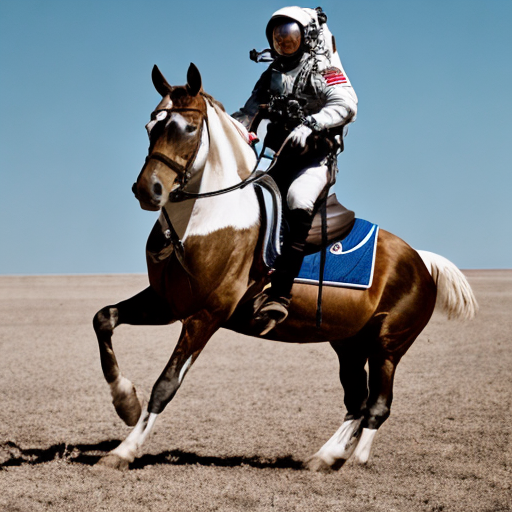

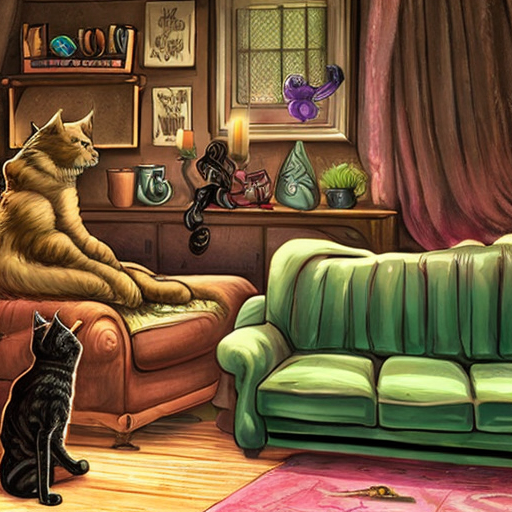

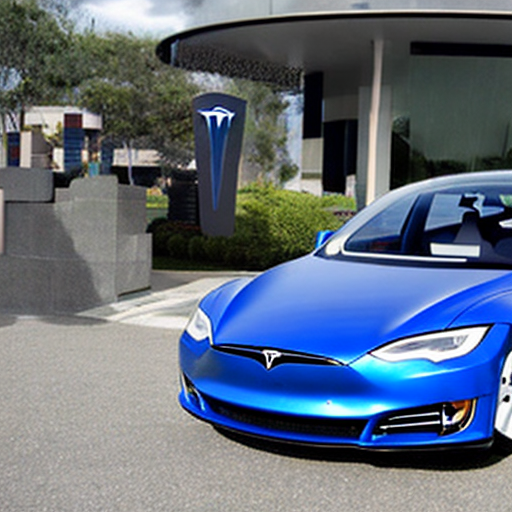

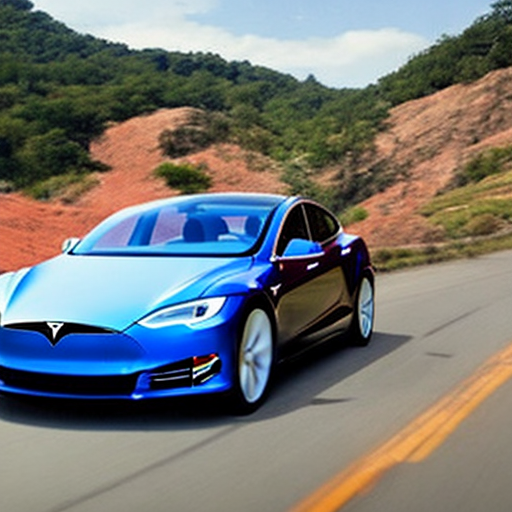

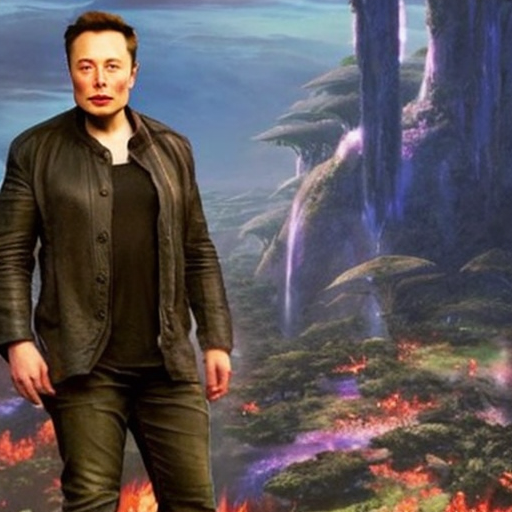

In [24]:
s3_client = boto_session.client("s3")

from PIL import Image
from io import BytesIO
result = s3_client.list_objects(Bucket=output_s3_bucket, Prefix=output_s3_prefix)
for obj in result.get("Contents"):
    data = s3_client.get_object(Bucket=output_s3_bucket, Key=obj.get("Key"))
    img = Image.open(BytesIO(data["Body"].read()))
    img.show()